Author: Robert Twyman
Copyright 2021 UCL
This file is part of STIR.

SPDX-License-Identifier: Apache-2.0
See STIR/LICENSE.txt for details


# Script for plotting and investigating GE singles information
It was observed that the STIR `construct_randoms_from_GEsingles` utility was overestimating the randoms from singles by approximately 25% to 33%.
This script investigates the decay rate of the singles, logged by `print_GE_singles_values`, by extracting the logged information into numpy arrays, plotting the total number of singles per second and tries to fit the measured data.

# Initial commentary
It was considered that there was an overestimation of randoms due to issues with decay/deadtime.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Core Functions

In [2]:
# Functions to convert between lambda and half-life
def get_lambda(half_life):
    return np.log(2) / half_life

def get_half_life(lbda):
    return np.log(2) / lbda

In [3]:
# Linear and decay functions
def linear_function(m, x, c):
    return m * x + c

def decay_function(lbda, x, S0):
    return S0 * np.exp(-lbda * x)

In [4]:
def get_lines_from_file(filename):
    print(f"Loading lines from file: \n  {filename}")
    with open(filename) as f:
        lines = f.readlines()
    return lines

def extract_singles_values_array_from_lines(lines):
    """
    This is a poorly written function that loops over each of the lines of the log file.
    The function filters the lines, looking for array depth information, given by "{" and "}".
    There are a few lines begining with "(" or "Time frame" or are empty that are ignored.
    """
    print("\nExtracting singles values array from lines...")
    line_num = 0
    num_lines = len(lines)
    singles_values = [[]]
    i = 0
    for l in lines:
        line_num += 1
        if line_num % 100 == 0:
            print(f"  Processing {line_num}/{num_lines} ({round(line_num / num_lines * 1000) / 10}%) lines...",
                  end="\r") # funky way to give percentages with decimal, e.g. 12.3%

        # Remove unneeded lines
        if len(l) <= 1 or l.startswith("(") or l.startswith("Time frame"):
            continue
            
        if l.count("{") == 2:
            # Increasing list depth
            i += 1
            singles_values.append([])
            
        if l.startswith(", "):
            # first 2 characters of the line are ", ", which we remove here.
            l = l[2::] 
            
        # remove any "{", "}", "\n" and split the remaining string into a list by "," as the delimiter.
        # Do not edit the original l
        tmp = l.replace("{", "").replace("}", "").replace("\n", "").split(",")
        
        
        if len(tmp) > 1:
            # Expect a list of some length, otherwise it may be an empty, which is discarded here.
            tmp = [float(i) for i in tmp] # Convert strings into float values.
            singles_values[i].append(tmp) 
            
    print(f"  Processed {line_num}/{num_lines} lines.")
    print("Converting to array...\n")
    return np.array(singles_values) # Ideally this whole function uses arrays rather than lists, this conversion is expensive.

# Main script

In [5]:
# This next line is the main argument for the script. This should be a GE list mode file. 
# For development, I have hard coded this line.

In [6]:
lm_file = "/Users/roberttwyman/bin/Experiments/Phantoms/GE_data/OriginalFiles/torso-phantom-DMI3ring-RDF9/list/LIST0000.blfun"

Output the print_GE_singles_values into a log file. No need to rerun once it has been run once.

In [7]:
log_file = "print_GE_singles_values.log"
if not os.path.isfile(log_file):
    print(f"Running print_GE_singles_values command! Saving into {log_file}")
    os.system(f"print_GE_singles_values {lm_file} > {log_file}")
else:
    print(f"{log_file} already exists.")

print_GE_singles_values.log already exists.


Load the log file in text and imediately load into a function to extract the lines into an array

In [8]:
singles_values = extract_singles_values_array_from_lines(get_lines_from_file(log_file))

Loading lines from file: 
  print_GE_singles_values.log

Extracting singles values array from lines...
  Processed 100832/100832 lines.0%) lines...
Converting to array...



In [9]:
seconds = np.array([i for i in range(len(singles_values))]) # Assume each array corresponds to one second

In [10]:
# for i in range(len(singles_values)):
#     singles_per_second[i] = np.sum(singles_values[i])
singles_per_second = np.array([np.sum(singles_values[i]) for i in range(len(singles_values))])

In [11]:
print(seconds)

[   0    1    2 ... 3598 3599 3600]


Take the natural log of the decay function gives a linear function 
`log( S0 exp(-2lambda t) = log(S0) -2lambda t )`. 
Fit the data in `singles_per_second` to a linear function and compute `lbda` (lambda) and `S0`

In [12]:
lbda, S0 = np.polyfit(seconds, np.log(singles_per_second), 1)
lbda = -lbda
S0 = np.exp(S0)
measured_half_life = get_half_life(lbda) # Convert lbda into half-life
exponential_fit = [decay_function(lbda, t, S0) for t in seconds]

# The first line of this print is a sanity check, expect value to be close to 1.
print(f"sum(singles_per_second) / sum(exponential_fit) = {np.sum(singles_per_second) / np.sum(exponential_fit)}\n",
      f"measured half life from polyfit = {measured_half_life} seconds")

sum(singles_per_second) / sum(exponential_fit) = 1.0000035290640472
 measured half life from polyfit = 7914.8479469115355 seconds


Compute expected behaviour based upon F18 half-life and compare the difference in the number of singles.

In [13]:
F18_half_life = 6586.2
F18_lbda = get_lambda(F18_half_life)
F18_singles = [decay_function(F18_lbda, t, S0) for t in seconds]
print(f"sum(F18_singles) / sum(exponential_fit) = {np.sum(F18_singles) / np.sum(exponential_fit)}\n",
      f"F18_half_life = {F18_half_life} seconds.")

sum(F18_singles) / sum(exponential_fit) = 0.9704810150331992
 F18_half_life = 6586.2 seconds.


Plot the three singles rates here.

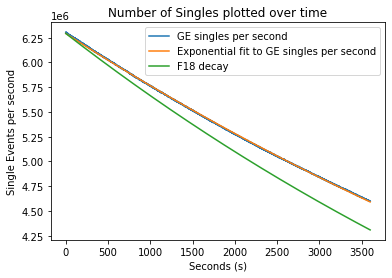

In [14]:
plt.figure()
plt.plot(singles_per_second)
plt.plot(exponential_fit)
plt.plot(F18_singles)
plt.title("Number of Singles plotted over time")
plt.legend(["GE singles per second", 
            "Exponential fit to GE singles per second", 
            "F18 decay"])
plt.ylabel("Single Events per second")
plt.xlabel("Seconds (s)")
plt.show()

In [15]:
print(f"sum(singles_per_second) / sum(exponential_fit) = {np.sum(singles_per_second) / np.sum(exponential_fit)}\n",
      f"sum(F18_singles) / sum(exponential_fit) = {np.sum(F18_singles) / np.sum(exponential_fit)}\n",
      f"measured half_life = {measured_half_life}\n\n"
      f"F18_half_life = {F18_half_life}")

sum(singles_per_second) / sum(exponential_fit) = 1.0000035290640472
 sum(F18_singles) / sum(exponential_fit) = 0.9704810150331992
 measured half_life = 7914.8479469115355

F18_half_life = 6586.2


# Discussion of decay investigation results
The above fit and plot indicates that the singles are sensitive to an alternative cause than just radioactive decay, as indicaed by the measured half-life being greater than the F18 value. 

An explaination for this may be detector deadtime. If this is the case we need to reconsider the plot.
At low singles rate the impact due to deadtime would be insignificant, therefore we would expect the `GE singles per second` and the `Exponential fit` plots to intersect. _N.B. This intersection would likely not appear on the range of this figure._ It is expected that the measured `S0` would be too small in this case as the current value is influnced by deadtime.

# Sum over alternative axis of `singles_values`

The following is a little additional investigation conducted. Sum over each of the time interval to give the sum for each detector-ring pair over time.

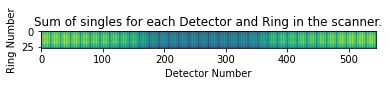

In [16]:
plt.figure()
plt.imshow(np.sum(singles_values, axis=0))
plt.title("Sum of singles for each Detector and Ring in the scanner.")
plt.xlabel("Detector Number")
plt.ylabel("Ring Number")
plt.show()

Sum over each time intervals and the rings. Flip the vector to see structure. 

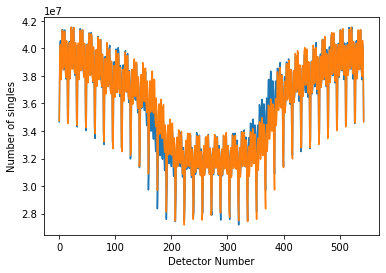

In [17]:
plt.figure()
plt.plot(np.sum(singles_values, axis=(0,1)))
plt.plot(np.flip(np.sum(singles_values, axis=(0,1))))
plt.xlabel("Detector Number")
plt.ylabel("Number of singles")
plt.show()

Sum over the time intervals and the detectors. Flip to see structure.

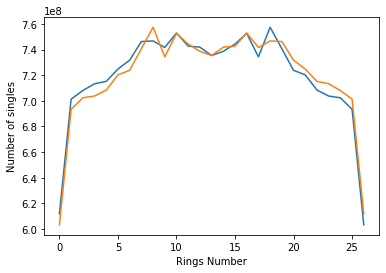

In [18]:
plt.figure()
plt.plot(np.sum(singles_values, axis=(0,2)))
plt.plot(np.flip(np.sum(singles_values, axis=(0,2))))
plt.xlabel("Rings Number")
plt.ylabel("Number of singles")
plt.show()

# A general conclusion
We see the expected sinusoidal behaviour over the detectors but in the rings we may observe higher activity at one axial extremity due to activity of the source.